In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_brno = pd.read_csv('brno_processed_data_15mAGL(in).csv')
df_brno.head()

longitude   latitude  altitude  lidar(m)  height_wgs84(m)  cs_photo  \
0  17.021266  49.299371  281.3081     0.053         323.3544  1.185422   
1  17.021265  49.299369  280.9034     0.059         322.9496  1.640932   
2  17.021265  49.299368  280.6013     0.057         322.6477  4.508131   
3  17.021265  49.299368  280.5653     0.053         322.6115  1.347647   
4  17.021265  49.299368  280.7359     0.059         322.7819  3.564847   

   co_photo  
0  0.000000  
1  1.187041  
2  0.668941  
3  0.000000  
4  1.188282

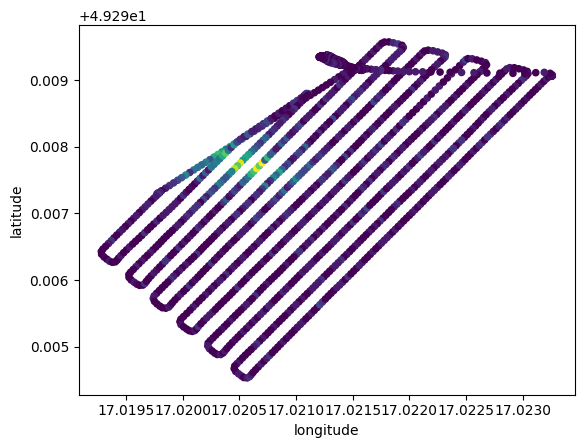

In [2]:
from matplotlib import pyplot as plt
df_brno.plot(kind='scatter', x='longitude', y='latitude',c = df_brno['co_photo'])
plt.gca().spines[['top', 'right',]].set_visible(True)

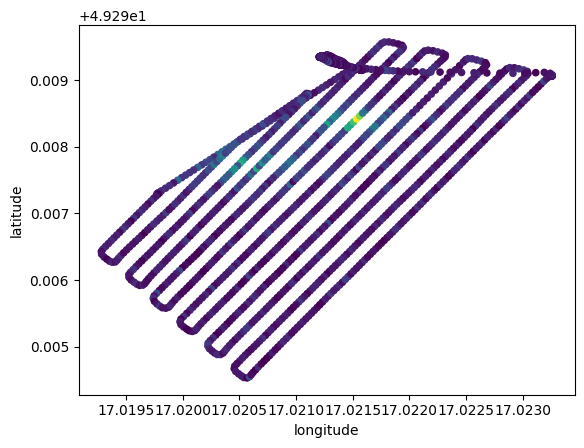

In [3]:
from matplotlib import pyplot as plt
df_brno.plot(kind='scatter', x='longitude', y='latitude',c = df_brno['cs_photo'])
plt.gca().spines[['top', 'right',]].set_visible(True)

In [4]:
import open3d as o3d
import numpy as np
cloud = o3d.io.read_point_cloud('iaea_model_vox1m.pcd')
# print(np.asarray(cloud.points))
# print(np.asarray(cloud.colors))
# print(np.asarray(cloud.normals))
from open3d.visualization import draw_plotly
draw_plotly([cloud])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Testing ill-conditioned

In [12]:
import numpy as np
import open3d as o3d
from pyproj import Transformer
import pandas as pd
from scipy.spatial import ConvexHull, distance # Import distance for cdist
from matplotlib.path import Path
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from tqdm import tqdm
import random
import time # For timing the operations

# Import Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Optional: prettier fonts for publication-style visuals
rcParams.update({
    'font.family': 'serif',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

# --- Helper Functions (Necessary for the algorithms to run) ---

def wgs_to_utm(df, lat_col='latitude', lon_col='longitude', alt_col='lidar(m)'):
    transformer = Transformer.from_crs("epsg:4326", "epsg:32633", always_xy=True)
    lon, lat, alt = df[lon_col].values, df[lat_col].values, df[alt_col].values
    x, y = transformer.transform(lon, lat)
    return np.stack([x, y, alt], axis=1).astype(np.float32)

def extract_detector_positions(df):
    return wgs_to_utm(df, lat_col='latitude', lon_col='longitude', alt_col='height_wgs84(m)')

def create_reconstruction_grid_extent(min_x, max_x, min_y, max_y, voxel_size=0.25):
    grid_x = np.arange(min_x + voxel_size/2, max_x + voxel_size/2, voxel_size)
    grid_y = np.arange(min_y + voxel_size/2, max_y + voxel_size/2, voxel_size)
    bounds_dict = {"x": (min_x, max_x), "y": (min_y, max_y)}
    return grid_x, grid_y, bounds_dict

def _kaczmarz_base(detectors, grid_points, b, isotope):
    m, n = detectors.shape[0], grid_points.shape[0]
    x = np.zeros(n, dtype=np.float32)

    if isotope.lower() == "cs":
        emission_prob = 0.851
        mu_over_rho = 0.07925
    elif isotope.lower() == "co":
        emission_prob = 0.999
        mu_over_rho = 0.05270
    else:
        raise ValueError("Invalid isotope. Use 'cs' or 'co'.")

    rho_air = 0.001225
    mu_L = mu_over_rho * rho_air * 100
    return x, m, n, emission_prob, mu_L

def _get_A_matrix(detectors, grid_points, emission_prob, mu_L):
    """Precomputes the A matrix where A[i, j] represents the contribution
    from grid point j to detector i. This is the main optimization."""
    print("\nPre-computing A matrix...")
    start_time = time.time()
    dists = np.linalg.norm(detectors[:, None, :] - grid_points[None, :, :], axis=2) + 1e-6
    atten = np.exp(-mu_L * dists)
    A_matrix = emission_prob / (4 * np.pi * dists**2) * atten
    end_time = time.time()
    print(f"A matrix pre-computation completed in {end_time - start_time:.2f} seconds. Shape: {A_matrix.shape}")
    return A_matrix

def calculate_system_residual(x_recon, b, A_matrix):
    """Calculates the L2 norm of the residual (||b - Ax||_2) using the pre-computed A_matrix."""
    predicted_b = A_matrix @ x_recon
    full_residual = b - predicted_b
    return np.linalg.norm(full_residual)


In [72]:
cloud = o3d.io.read_point_cloud("converted_coloured.ply")
original_terrain_points = np.asarray(cloud.points)
df_brno = pd.read_csv("brno_processed_data_15mAGL(in).csv")
detectors = extract_detector_positions(df_brno)

# --- Data and Grid Setup ---
b_cs = df_brno['cs_photo'].values.astype(np.float32)
b_co = df_brno['co_photo'].values.astype(np.float32)

buffer_distance = 50.0
det_min_x, det_max_x = detectors[:, 0].min(), detectors[:, 0].max()
det_min_y = detectors[:, 1].min()
det_max_y = detectors[:, 1].max()

grid_min_x, grid_max_x = det_min_x - buffer_distance, det_max_x + buffer_distance
grid_min_y, grid_max_y = det_min_y - buffer_distance, det_max_y + buffer_distance
grid_x, grid_y, _ = create_reconstruction_grid_extent(grid_min_x, grid_max_x, grid_min_y, grid_max_y, voxel_size=12.0)
xx_mesh, yy_mesh = np.meshgrid(grid_x, grid_y, indexing='ij')
Z_terrain_interpolated = griddata(original_terrain_points[:, :2], original_terrain_points[:, 2], 
                                (xx_mesh, yy_mesh), method='nearest')
grid_points_for_reconstruction = np.stack([xx_mesh.ravel(), yy_mesh.ravel(), Z_terrain_interpolated.ravel()], axis=1).astype(np.float32)
print("Pre-computing A matrix for Cs...")
_, _, _, emission_prob_cs, mu_L_cs = _kaczmarz_base(detectors, grid_points_for_reconstruction, b_cs, isotope="cs")
A_matrix_cs = _get_A_matrix(detectors, grid_points_for_reconstruction, emission_prob_cs, mu_L_cs)

print("Pre-computing A matrix for Co...")
_, _, _, emission_prob_co, mu_L_co = _kaczmarz_base(detectors, grid_points_for_reconstruction, b_co, isotope="co")
A_matrix_co = _get_A_matrix(detectors, grid_points_for_reconstruction, emission_prob_co, mu_L_co)


Pre-computing A matrix for Cs...

Pre-computing A matrix...
A matrix pre-computation completed in 0.16 seconds. Shape: (1813, 1792)
Pre-computing A matrix for Co...

Pre-computing A matrix...
A matrix pre-computation completed in 0.13 seconds. Shape: (1813, 1792)


# Condition

In [45]:
import numpy as np
import warnings

def check_condition_number(A_matrix):
    """
    Calculates and prints the condition number of the system matrix A.
    A high condition number (>1e6) indicates the problem is ill-conditioned.

    Args:
        A_matrix (np.ndarray): The system matrix A.
    """
    # warnings.simplefilter('ignore', np.ComplexWarning)
    try:
        # Use np.linalg.cond to get the 2-norm condition number
        cond_num = np.linalg.cond(A_matrix)
        print(f"Condition Number of A: {cond_num:.4e}")
        
        # Interpret the result
        if cond_num > 1e6:
            print("The system is highly ILL-CONDITIONED. This is a common characteristic of inverse problems.")
            print("You must use regularization techniques (like a smaller relaxation parameter or early stopping) to find a stable solution.")
        else:
            print("The system is WELL-CONDITIONED.")
    except np.linalg.LinAlgError:
        print("Could not compute the condition number. The matrix is likely singular or not a square matrix.")

# --- Main Execution Block to demonstrate usage ---
if __name__ == '__main__':
    # Assume A_matrix_cs and A_matrix_co have been pre-computed from your main script
    
    # --- Example with a placeholder matrix ---
    # For a realistic run, replace this with your actual A_matrix_cs
    print("\n--- Checking an Example Matrix (simulating a good case) ---")
    A_well_conditioned = np.array([[1, 2], [3, 4]])
    check_condition_number(A_well_conditioned)

    # --- Example with a placeholder matrix ---
    # For a realistic run, replace this with your actual A_matrix_co
    print("\n--- Checking an Example Matrix (simulating an ill-conditioned case) ---")
    A_ill_conditioned = np.array([[1, 1.0001], [1, 1]])
    check_condition_number(A_ill_conditioned)

    # --- Run with your actual pre-computed matrices ---
    # This will assume you have already loaded your data and built the A matrices
    print("\n--- Checking the Condition Number for your Cesium Matrix ---")
    check_condition_number(A_matrix_cs)

    print("\n--- Checking the Condition Number for your Cobalt Matrix ---")
    check_condition_number(A_matrix_co)


--- Checking an Example Matrix (simulating a good case) ---
Condition Number of A: 1.4933e+01
The system is WELL-CONDITIONED.

--- Checking an Example Matrix (simulating an ill-conditioned case) ---
Condition Number of A: 4.0002e+04
The system is WELL-CONDITIONED.

--- Checking the Condition Number for your Cesium Matrix ---
Condition Number of A: 1.9786e+14
The system is highly ILL-CONDITIONED. This is a common characteristic of inverse problems.
You must use regularization techniques (like a smaller relaxation parameter or early stopping) to find a stable solution.

--- Checking the Condition Number for your Cobalt Matrix ---
Condition Number of A: 6.3905e+13
The system is highly ILL-CONDITIONED. This is a common characteristic of inverse problems.
You must use regularization techniques (like a smaller relaxation parameter or early stopping) to find a stable solution.


In [46]:
import numpy as np

def check_condition_svd(A_matrix):
    """
    Calculates the condition number of a matrix using Singular Value Decomposition (SVD).
    
    Args:
        A_matrix (np.ndarray): The system matrix A.
    
    Returns:
        float: The condition number.
    """
    try:
        # Perform SVD and get the singular values
        U, s, Vt = np.linalg.svd(A_matrix)
        
        # The singular values are sorted in descending order
        sigma_max = s[0]
        
        # The smallest singular value is the last element. We check for near-zero.
        
        sigma_min = s[-1]
        cond_num = sigma_max / sigma_min
            
        print(f"Condition Number of A (SVD): {cond_num:.4e}")
        print(f"Smallest Singular Value (SVD): {sigma_min:.4e}")
        print(f"Largest Singular Value (SVD): {sigma_max:.4e}")
        return cond_num
        
    except np.linalg.LinAlgError:
        print("Could not compute SVD. The matrix is likely not a 2D array.")
        return np.inf

# --- Main Execution Block to demonstrate usage ---
if __name__ == '__main__':
    # Assume A_matrix_cs and A_matrix_co have been pre-computed
    # and are available in your script.

    # Example placeholder matrices for demonstration
    A_well = np.array([[1, 2], [3, 4]])
    A_ill = np.array([[1, 1], [1, 1.0001]])

    print("\n--- Checking an Example Well-Conditioned Matrix ---")
    check_condition_svd(A_well)

    print("\n--- Checking an Example Ill-Conditioned Matrix ---")
    check_condition_svd(A_ill)

    # To run with your matrices, uncomment these lines in your main script:
    print("\n--- Checking the Condition Number for your Cesium Matrix (SVD) ---")
    check_condition_svd(A_matrix_cs)

    print("\n--- Checking the Condition Number for your Cobalt Matrix (SVD) ---")
    check_condition_svd(A_matrix_co)


--- Checking an Example Well-Conditioned Matrix ---
Condition Number of A (SVD): 1.4933e+01
Smallest Singular Value (SVD): 3.6597e-01
Largest Singular Value (SVD): 5.4650e+00

--- Checking an Example Ill-Conditioned Matrix ---
Condition Number of A (SVD): 4.0002e+04
Smallest Singular Value (SVD): 4.9999e-05
Largest Singular Value (SVD): 2.0001e+00

--- Checking the Condition Number for your Cesium Matrix (SVD) ---
Condition Number of A (SVD): 1.9663e+14
Smallest Singular Value (SVD): 2.9323e-16
Largest Singular Value (SVD): 5.7657e-02

--- Checking the Condition Number for your Cobalt Matrix (SVD) ---
Condition Number of A (SVD): 6.3905e+13
Smallest Singular Value (SVD): 1.0791e-15
Largest Singular Value (SVD): 6.8959e-02


In [73]:
import numpy as np
import matplotlib.pyplot as plt

def run_discrete_picard_test(A_matrix, b_vector, noise_estimate=None):
    """
    Performs the Discrete Picard Test to analyze an inverse problem.

    Args:
        A_matrix (np.ndarray): The system matrix A.
        b_vector (np.ndarray): The measurement vector b.
        noise_estimate (float, optional): An estimate of the noise level in b.
                                         If provided, a horizontal line will be plotted.
    """
    print("Running Discrete Picard Test...")
    try:
        # 1. Perform Singular Value Decomposition (SVD)
        U, s, Vt = np.linalg.svd(A_matrix, full_matrices=False)
        
        # 2. Project the data vector 'b' onto the basis of the 'U' matrix
        u_t_b = U.T @ b_vector
        
        # 3. Calculate the solution components (b' / sigma)
        solution_components = np.abs(u_t_b) / s
        
        # 4. Create the plot
        plt.figure(figsize=(15,6))
        
        # --- Subplot 1: Singular Values ---
        ax1 = plt.subplot(1, 2, 1)
        ax1.semilogy(s, 'o-')
        ax1.set_title("Singular Values ($\sigma_i$)")
        ax1.set_xlabel("Index $i$")
        ax1.set_ylabel("Value (log scale)")
        ax1.grid(True)
        
        # --- Subplot 2: Projected Data Components ---
        ax2 = plt.subplot(1, 2, 2)
        ax2.semilogy(np.abs(u_t_b), 'o-')
        ax2.set_title("Projected Data $|u_i^T b|$")
        ax2.set_xlabel("Index $i$")
        ax2.set_ylabel("Value (log scale)")
        ax2.grid(True)
        if noise_estimate is not None:
            ax2.axhline(y=noise_estimate, color='r', linestyle='--', label='Noise Floor Estimate')
            ax2.legend()
            
        
        
    except np.linalg.LinAlgError:
        print("Could not perform SVD. The matrix might be singular or non-rectangular.")




--- Running Picard Test for Cesium-137 with Noise Estimate ---
Running Discrete Picard Test...


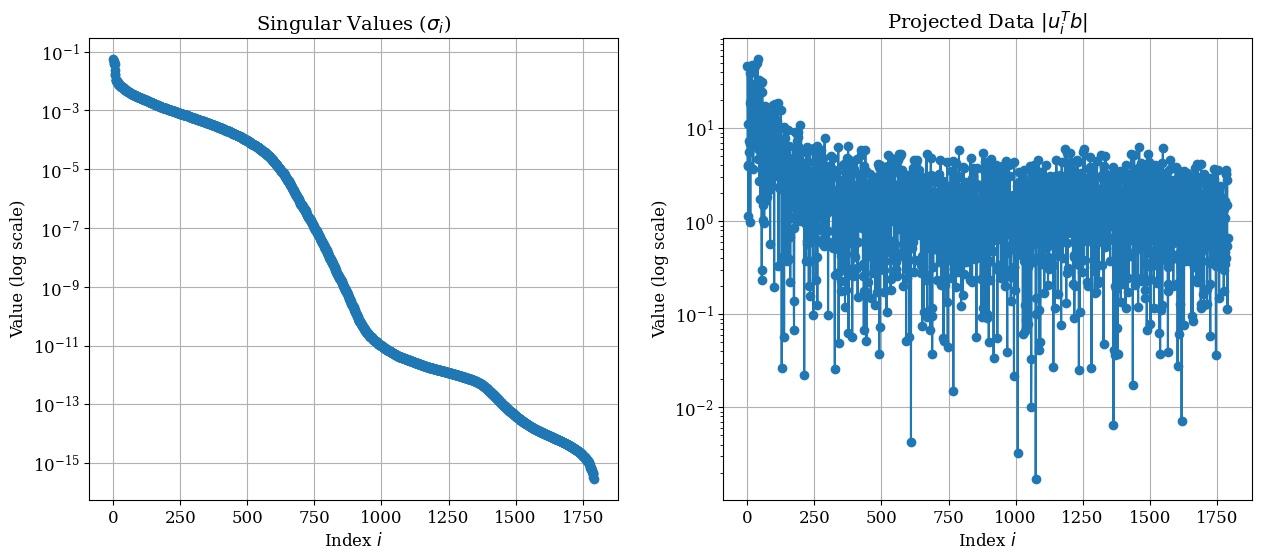

In [74]:
if __name__ == '__main__':
    # 3. Run the Discrete Picard Test with the estimated noise
    print("\n--- Running Picard Test for Cesium-137 with Noise Estimate ---")
    run_discrete_picard_test(A_matrix_cs, b_cs)

Running Discrete Picard Test...


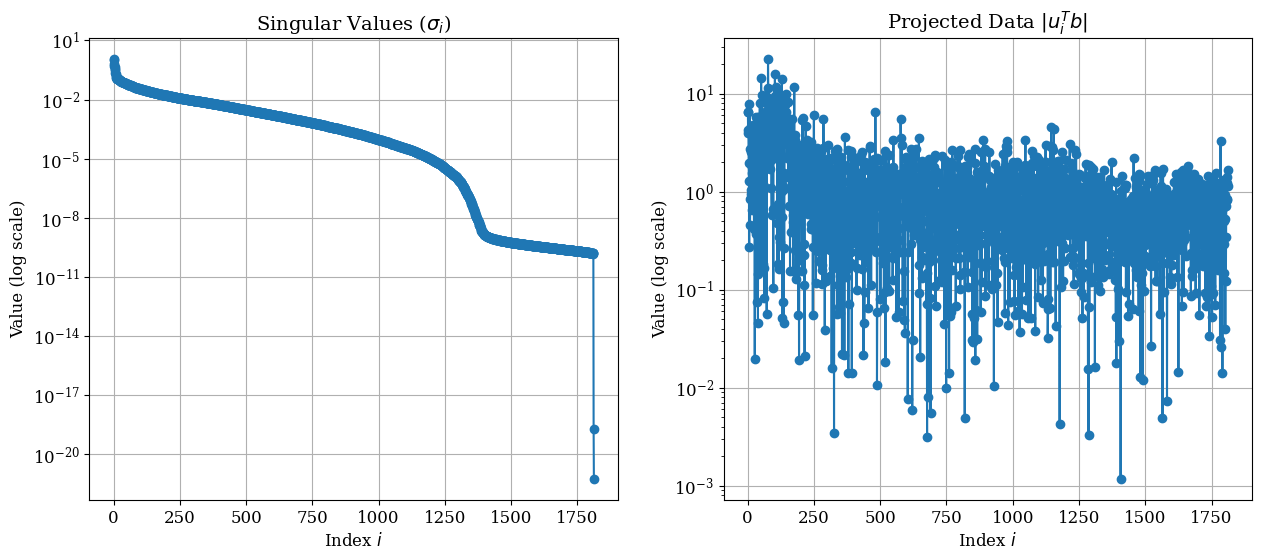

In [71]:
run_discrete_picard_test(A_matrix_co, b_co)

Running Discrete Picard Test...


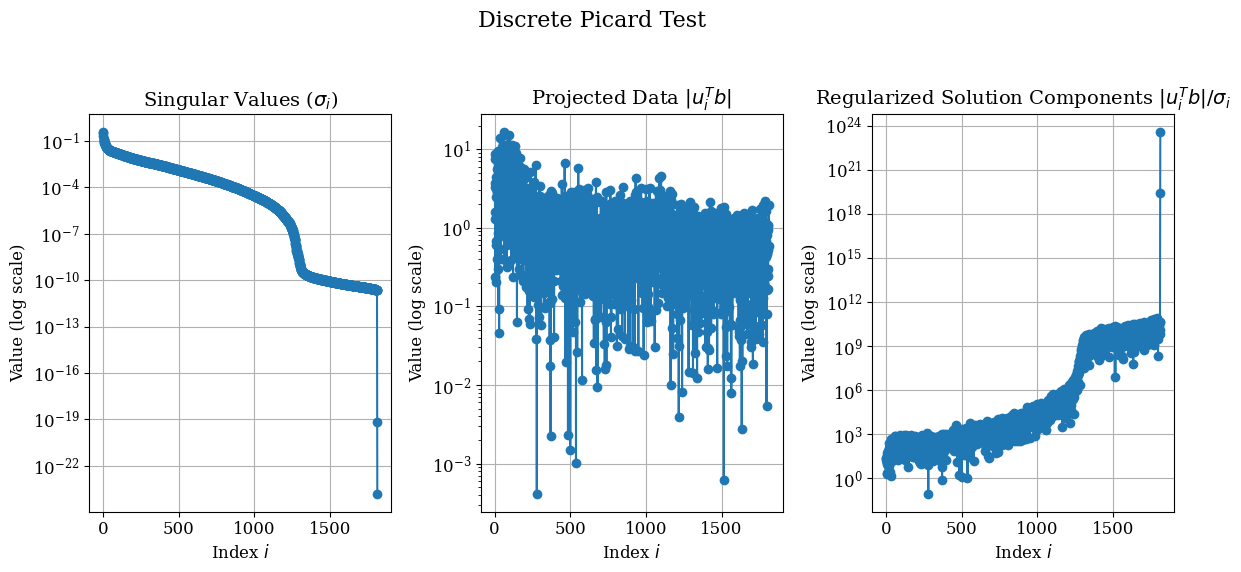

In [8]:
run_discrete_picard_test(A_matrix_co, b_co)

# Test

In [3]:
def plot_reconstruction_and_measurements_side_by_side2(x_recon, xx_mesh, yy_mesh, Z_terrain,
                                                     grid_points_for_reconstruction, detectors,
                                                     b_values, algo_name, isotope_str,
                                                     threshold_percentage=0.0):
    print(f"\nCreating side-by-side plot for {algo_name} ({isotope_str}) ...")

    # Create the figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)
    fig.suptitle(f"{algo_name} Reconstruction for {isotope_str.upper()}", fontsize=16)

    # --- Left Subplot: Reconstruction Map ---
    # Plot the terrain elevation as a background
    contour_levels = 50
    ax1.contourf(xx_mesh, yy_mesh, Z_terrain, levels=contour_levels, cmap='terrain', alpha=0.8)

    scatter_x = grid_points_for_reconstruction[:, 0]
    scatter_y = grid_points_for_reconstruction[:, 1]
    reconstruction_plot = ax1.scatter(scatter_x, scatter_y, c=x_recon,
                                     cmap='hot', s=50, alpha=0.7, edgecolors='none')
    fig.colorbar(reconstruction_plot, ax=ax1, label="Reconstructed Activity", pad=0.05)

    # Find and plot the highest reconstruction point
    max_recon_idx = np.argmax(x_recon)
    max_recon_loc = grid_points_for_reconstruction[max_recon_idx]
    ax1.scatter(max_recon_loc[0], max_recon_loc[1], s=50, marker='o', c='yellow', edgecolors='black', zorder=5)
    ax1.annotate(f"Peak\n({max_recon_loc[0]:.0f}, {max_recon_loc[1]:.0f})",
                 (max_recon_loc[0], max_recon_loc[1]),
                 textcoords="offset points", xytext=(-20,-20), ha='center', fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.7))

    ax1.set_title("Reconstruction Map")
    ax1.set_xlabel("UTM Easting (m)")
    ax1.set_ylabel("UTM Northing (m)")
    ax1.set_aspect('equal', adjustable='box')

    # --- Right Subplot: Drone Measurements ---
    # Plot the terrain elevation as a background
    #ax2.contourf(xx_mesh, yy_mesh, Z_terrain, levels=contour_levels, cmap='terrain', alpha=0.8)

    # Plot the drone flight path
    ax2.plot(detectors[:, 0], detectors[:, 1], color='black', linestyle='--', linewidth=1, zorder=2, label='Drone Path')

    # Plot the "true hotspot" measurements from the drone
    scatter_drone = ax2.scatter(detectors[:, 0], detectors[:, 1],
                               c=b_values, cmap='inferno', s=50, alpha=0.8,
                               edgecolors='black', linewidth=0.5, zorder=3)

    # Find and plot the highest drone measurement point
    max_b_idx = np.argmax(b_values)
    max_b_loc = detectors[max_b_idx]
    ax2.scatter(max_b_loc[0], max_b_loc[1], s=50, marker='o', c='yellow', edgecolors='black', zorder=5)
    ax2.annotate(f"Peak\n({max_b_loc[0]:.0f}, {max_b_loc[1]:.0f})",
                 (max_b_loc[0], max_b_loc[1]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5, alpha=0.7))

    # Add a colorbar for the drone measurements
    fig.colorbar(scatter_drone, ax=ax2, label="Drone Measurement Intensity (counts)", pad=0.05)

    # Add arrow to indicate start of path
    if len(detectors) > 1:
        ax2.arrow(detectors[0, 0], detectors[0, 1],
                  detectors[1, 0] - detectors[0, 0], detectors[1, 1] - detectors[0, 1],
                  head_width=5, head_length=5, fc='black', ec='black', zorder=4)

    ax2.set_title(f"Drone Measurement Map (Raw {isotope_str.upper()} Data)")
    ax2.set_xlabel("UTM Easting (m)")
    ax2.set_aspect('equal', adjustable='box')
    ax2.legend()

    plt.tight_layout()
    plt.show()

    # --- Print the comparison ---
    print("\n--- Peak Location Comparison ---")
    print(f"Reconstructed Peak Location (UTM): ({max_recon_loc[0]:.2f}, {max_recon_loc[1]:.2f})")
    print(f"Measured Peak Location (UTM): ({max_b_loc[0]:.2f}, {max_b_loc[1]:.2f})")
    distance = np.linalg.norm(max_recon_loc[:2] - max_b_loc[:2])
    print(f"Distance between peaks: {distance:.2f} meters")


In [4]:
import numpy as np
x_pinv = np.linalg.pinv(A_matrix_cs) @ b_cs



Creating side-by-side plot for Direct Inversion (cs) ...


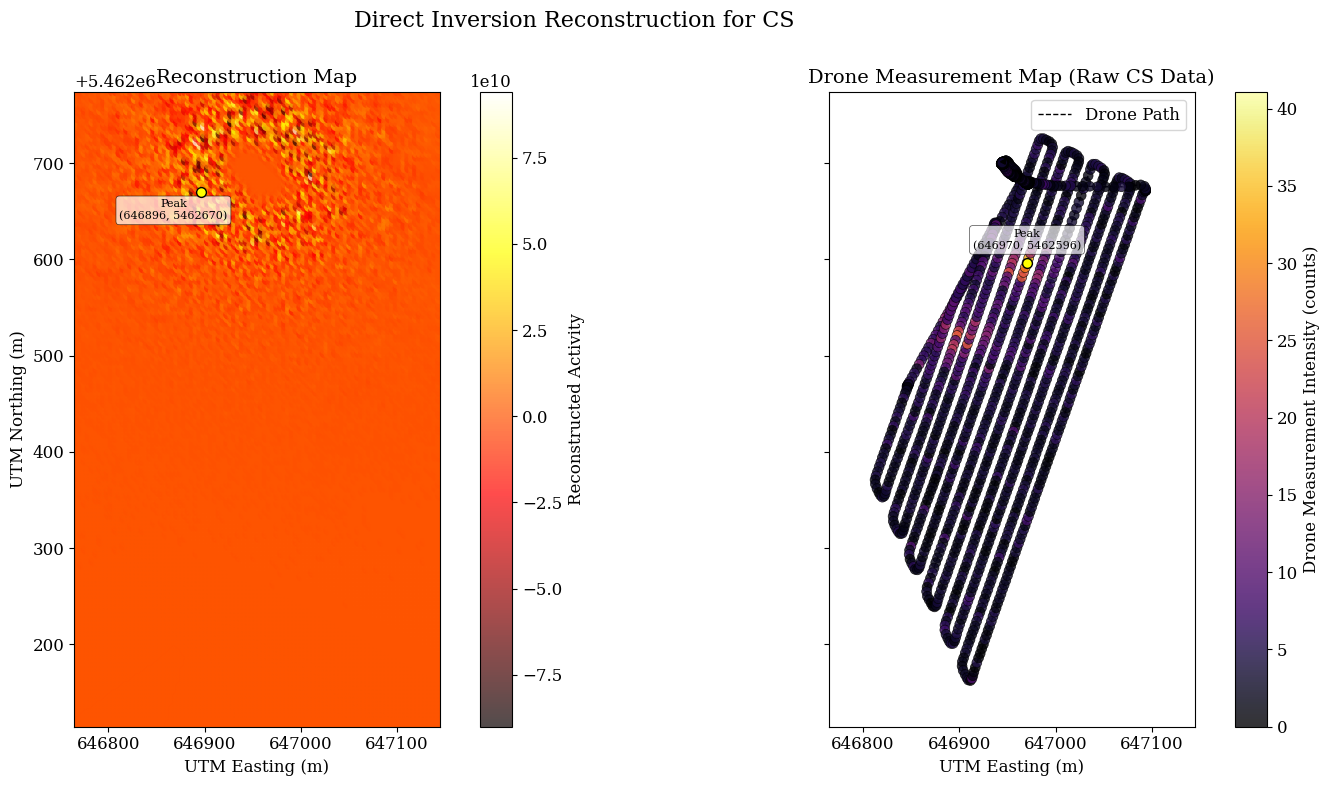


--- Peak Location Comparison ---
Reconstructed Peak Location (UTM): (646896.50, 5462670.50)
Measured Peak Location (UTM): (646970.38, 5462596.50)
Distance between peaks: 104.56 meters


In [ ]:
plot_reconstruction_and_measurements_side_by_side2(x_pinv, xx_mesh, yy_mesh, Z_terrain_interpolated,
                                                     grid_points_for_reconstruction, detectors,
                                                     b_cs, "Direct Inversion", 'cs')
